In [1]:
from framework import Featurizer
from dqn import DQNAgent, DQNTrainer

import gym
import numpy as np

In [2]:
env = gym.make('InvertedDoublePendulum-v4', render_mode='rgb_array')
env.action_space = np.linspace(env.action_space.low, env.action_space.high, 21) # discretize action space
state_dim = env.observation_space.shape[0]

featurizer = Featurizer(state_dim) # apply adaptive scaling to state vectors
agent = DQNAgent( 
                 input_dim=state_dim, # neural net params
                 output_dim=env.action_space.shape[0],
                 hidden_dim=128,
                 hidden_layers=5,
                 batch_size=256,
                 gamma=0.99, # discount factor
                 min_epsilon=0.1, epsilon_decay=0.999, # exploration rate
                 tau=0.005 # update rate of target net
                )

trainer = DQNTrainer(env, agent, featurizer)

In [3]:
trainer.train(episodes=1000)

100%|██████████| 1000/1000 [00:46<00:00, 21.37it/s]


In [4]:
info = trainer.run_episode(False)
print(f"cumulative reward: {info['reward']:.2f}, steps: {info['steps']}")

cumulative reward: 9331.88, steps: 1000


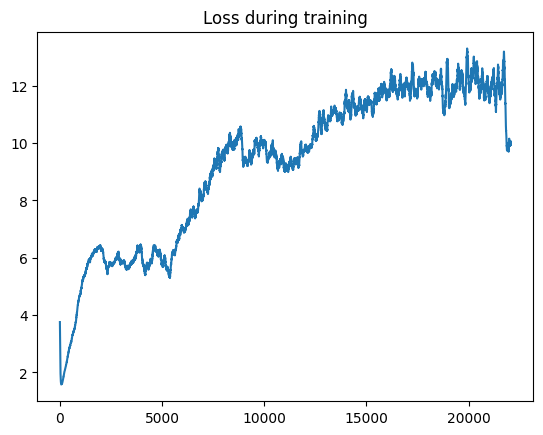

In [5]:
trainer.plot_losses()

In [6]:
from PIL import Image
frames = []
matrices = info['rgb_arrays']
for matrix in matrices:
    image = Image.fromarray(matrix, mode='RGB')
    frames.append(image)

frames[0].save("simulation.gif", save_all=True, append_images=frames[1:], duration=25, loop=0)